In [1]:
!pip install graphviz

In [136]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from reader import generic_reader
import seaborn as sns
import os
import ast
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"
import graphviz

In [137]:
df_danish_actors = generic_reader.read_csv_file_to_data_frame("../movie_data/danish_actors.csv")
df_danish_movies = generic_reader.read_csv_file_to_data_frame("../movie_data/danish_movies.csv")

In [138]:
list(df_danish_movies)

['adult',
 'backdrop_path',
 'budget',
 'homepage',
 'id',
 'imdb_id',
 'origin_country',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'genre_ids',
 'production_company_ids',
 'collection_id',
 'cast_person_ids',
 'cast_credit_ids',
 'crew_person_ids',
 'crew_credit_ids']

In [139]:
print(df_danish_actors.columns)

Index(['actor_id', 'movie_ids', 'adult', 'also_known_as', 'biography',
       'birthday', 'deathday', 'gender', 'homepage', 'imdb_id',
       'known_for_department', 'name', 'place_of_birth', 'popularity',
       'profile_path'],
      dtype='object')


In [140]:
# Dropping columns which won't be needed
columns_to_drop = ['name', 'adult', 'also_known_as', 'biography', 'deathday', 
                   'homepage', 'imdb_id', 'known_for_department', 'place_of_birth', 'profile_path']
  
df_clean_actors = df_danish_actors.drop(columns=columns_to_drop)

# Convert string representation of sets to actual sets
df_clean_actors['movie_ids'] = df_clean_actors['movie_ids'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
)

# Explode to one row per actor per movie
df_clean_actors = df_clean_actors.explode('movie_ids')

# Rename for clarity
df_clean_actors = df_clean_actors.rename(columns={'movie_ids': 'movie_id'})

# Convert movie_id to int
df_clean_actors['movie_id'] = df_clean_actors['movie_id'].astype(int)

# Convert birthday to datetime
df_clean_actors['birthday'] = pd.to_datetime(df_clean_actors['birthday'], errors='coerce')

# Create age feature from birthday
today = pd.Timestamp('today')
df_clean_actors['age'] = (today - df_clean_actors['birthday']).dt.days // 365

# Impute missing ages with median
imputer = SimpleImputer(strategy='median')
df_clean_actors['age'] = imputer.fit_transform(df_clean_actors[['age']])

# Reset index
df_clean_actors = df_clean_actors.reset_index(drop=True)

# Drop duplicate actor/movie pairs if any
df_clean_actors = df_clean_actors.drop_duplicates(subset=['actor_id', 'movie_id'])

print(df_clean_actors.head())
print(f"Number of rows after exploding: {len(df_clean_actors)}")


   actor_id  movie_id   birthday  gender  popularity   age
0        42    658817 1956-04-30       2      0.9635  69.0
1        42     29445 1956-04-30       2      0.9635  69.0
2        42    456325 1956-04-30       2      0.9635  69.0
3        42    752908 1956-04-30       2      0.9635  69.0
4        42   1354636 1956-04-30       2      0.9635  69.0
Number of rows after exploding: 44325


In [141]:
df_danish_movies.dtypes

adult                        bool
backdrop_path              object
budget                      int64
homepage                   object
id                          int64
imdb_id                    object
origin_country             object
original_language          object
original_title             object
overview                   object
popularity                float64
poster_path                object
production_countries       object
release_date               object
revenue                     int64
runtime                     int64
spoken_languages           object
status                     object
tagline                    object
title                      object
video                        bool
vote_average              float64
vote_count                  int64
genre_ids                  object
production_company_ids     object
collection_id             float64
cast_person_ids            object
cast_credit_ids            object
crew_person_ids            object
crew_credit_id

In [142]:
print(df_danish_movies.columns)

Index(['adult', 'backdrop_path', 'budget', 'homepage', 'id', 'imdb_id',
       'origin_country', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'genre_ids',
       'production_company_ids', 'collection_id', 'cast_person_ids',
       'cast_credit_ids', 'crew_person_ids', 'crew_credit_ids'],
      dtype='object')


In [143]:
# Droppping columns which won't be neeeded
columns_to_drop = ['adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'origin_country',
                   'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_countries', 'revenue',
                   'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'genre_ids',
                   'production_company_ids', 'collection_id', 'crew_person_ids', 'crew_credit_ids', 'cast_credit_ids']
df_clean_movies = df_danish_movies.drop(columns=columns_to_drop)

# Convert string representation of sets to actual lists
df_clean_movies['cast_person_ids'] = df_clean_movies['cast_person_ids'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else (list(x) if pd.notna(x) else [])
)

# Explode to one row per actor per movie
df_clean_movies = df_clean_movies.explode('cast_person_ids')

# Drop rows with missing actor_id
df_clean_movies = df_clean_movies.dropna(subset=['cast_person_ids'])

# Rename and convert actor_id
df_clean_movies = df_clean_movies.rename(columns={'cast_person_ids': 'actor_id'})
df_clean_movies['actor_id'] = df_clean_movies['actor_id'].astype(int)

# Convert release_date to datetime
df_clean_movies['release_date'] = pd.to_datetime(df_clean_movies['release_date'], errors='coerce')

# Reset index and drop duplicate actor/movie pairs
df_clean_movies = df_clean_movies.reset_index(drop=True)
df_clean_movies = df_clean_movies.drop_duplicates(subset=['id', 'actor_id'])


print(df_clean_movies.head())
print(f"Number of rows after exploding: {len(df_clean_movies)}")


        id release_date  vote_average  vote_count  actor_id
0   195139   1897-01-01           5.3          15   2452695
1   195364   1899-05-20           4.0           5   4658231
2   195364   1899-05-20           4.0           5   4658234
3   231776   1900-06-04           4.3           3   5301277
4  1188759   1902-02-02           0.0           0   1362101
Number of rows after exploding: 44325


In [144]:
df_clean_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44325 entries, 0 to 44368
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            44325 non-null  int64         
 1   release_date  44325 non-null  datetime64[ns]
 2   vote_average  44325 non-null  float64       
 3   vote_count    44325 non-null  int64         
 4   actor_id      44325 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.0 MB


In [145]:
df_clean_actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44325 entries, 0 to 44324
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   actor_id    44325 non-null  int64         
 1   movie_id    44325 non-null  int64         
 2   birthday    28867 non-null  datetime64[ns]
 3   gender      44325 non-null  int64         
 4   popularity  44325 non-null  float64       
 5   age         44325 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 2.0 MB


In [146]:
# Merge actors and movies on movie_id / id
df_merged = pd.merge(
    df_clean_actors,
    df_clean_movies.drop(columns=['actor_id']),  # drop actor_id from movies to keep only actor's version
    left_on='movie_id',
    right_on='id',
    how='inner'
)

# Drop the redundant 'id' column from movies
df_merged = df_merged.drop(columns=['id'])

# Reset index
df_merged = df_merged.reset_index(drop=True)

print(df_merged.info())
print(df_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971469 entries, 0 to 971468
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   actor_id      971469 non-null  int64         
 1   movie_id      971469 non-null  int64         
 2   birthday      613336 non-null  datetime64[ns]
 3   gender        971469 non-null  int64         
 4   popularity    971469 non-null  float64       
 5   age           971469 non-null  float64       
 6   release_date  971469 non-null  datetime64[ns]
 7   vote_average  971469 non-null  float64       
 8   vote_count    971469 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(4)
memory usage: 66.7 MB
None
   actor_id  movie_id   birthday  gender  popularity   age release_date  \
0        42    658817 1956-04-30       2      0.9635  69.0   2005-04-28   
1        42     29445 1956-04-30       2      0.9635  69.0   1987-09-11   
2        42     29445 1956-04

In [147]:
df_merged.isnull().sum()

actor_id             0
movie_id             0
birthday        358133
gender               0
popularity           0
age                  0
release_date         0
vote_average         0
vote_count           0
dtype: int64

In [148]:
df_merged.shape

(971469, 9)

In [149]:
array = df_merged.values

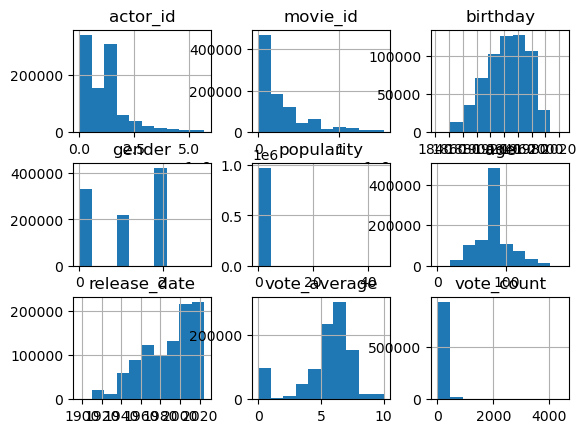

In [150]:
df_merged.hist()
plt.show()

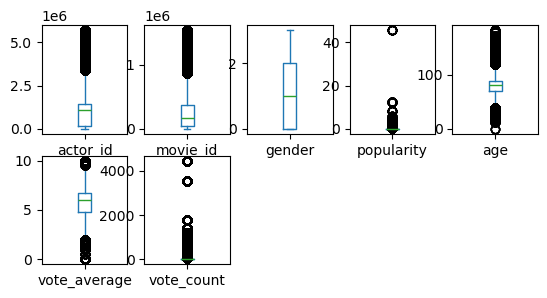

In [151]:
df_merged.plot(kind='box', subplots=True, layout=(3,5), sharex=False, sharey=False)
plt.show()

In [152]:
feature_cols = [
    'age',          
    'popularity',   
    'vote_average', 
    'vote_count',   
]
label_col = 'gender' 

In [154]:
array = df_merged[feature_cols + [label_col]].dropna().values

In [155]:
X, y = array[:, :-1], array[:, -1]

In [156]:
class0 = X[y == 0]
class1 = X[y == 1]
class2 = X[y == 2]   

In [157]:
set_prop = 0.20

In [158]:
seed = 12

In [159]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [160]:
params = {'max_depth': 5}
classifier = DecisionTreeClassifier(**params)
#classifier = RandomForestClassifier(n_estimators = 100, max_depth = 4)

In [161]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [164]:
dot_data = tree.export_graphviz(
    classifier,
    out_file=None,
    feature_names=feature_cols,
    class_names=[str(c) for c in np.unique(y)],
    filled=True, rounded=True, proportion=False,
    special_characters=True
)

In [165]:
graph = graphviz.Source(dot_data)
graph.render("danish_ML")

'danish_ML.pdf'

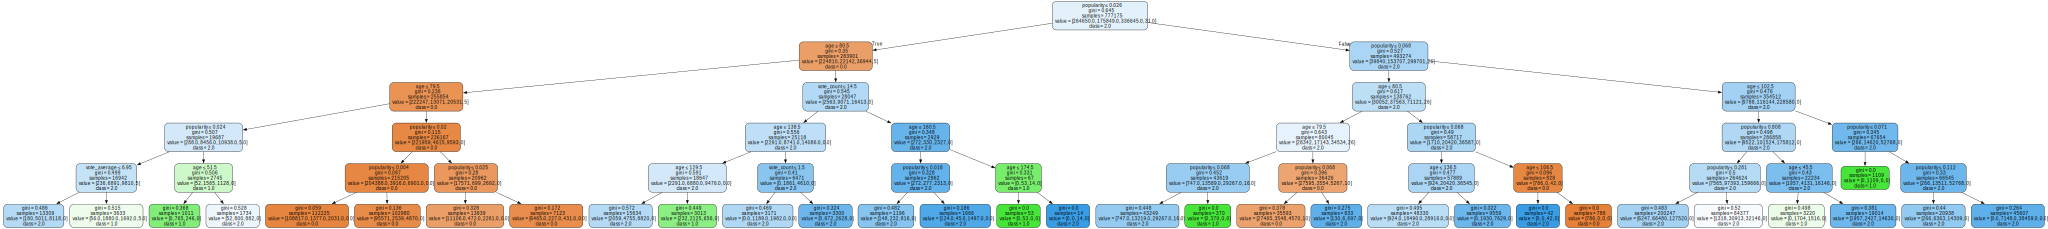

In [166]:
graph

In [167]:
scoring = 'accuracy'

In [168]:
y_testp = classifier.predict(X_test)
y_testp

array([2., 2., 2., ..., 0., 2., 2.])

In [169]:
y_test

array([1., 2., 2., ..., 0., 2., 0.])

In [170]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  0.7439704777296262


In [171]:
confusion_mat = confusion_matrix(y_test,y_testp)
confusion_mat

array([[62368,    64,  3599,     0],
       [ 2037,  1977, 39511,     0],
       [ 3469,  1055, 80204,     0],
       [    2,     0,     8,     0]])

In [172]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,0.0,1.0,2.0
row_0,,,
0.0,62368,64,3599
1.0,2037,1977,39511
2.0,3469,1055,80204
3.0,2,0,8


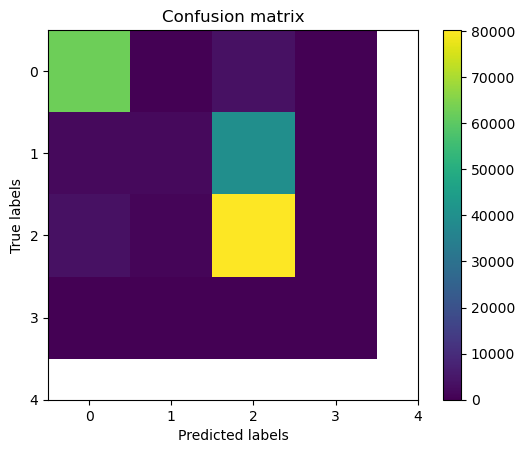

In [173]:
plt.imshow(confusion_mat, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(5)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

<Axes: >

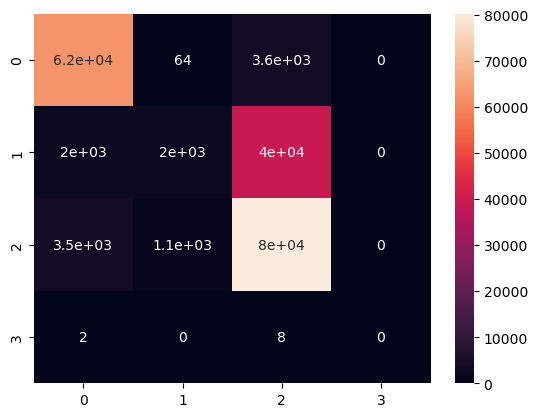

In [174]:
sns.heatmap(confusion_mat, annot=True)